In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples= n_samples,
                    noise=0.03,
                    random_state=42)

print(f"5 primeras instancias de X: \n {X[:5]}")
print(f"5 primeras instancias de Y: \n {y[:5]}")

### Pasarlo a un DataFrame de Pandas

In [ ]:
import pandas as pd

circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'y': y
})
circles

### Visualizar los datos con MatPlotLib

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(x=circles['X1'], y=circles['X2'], c=circles['y'], cmap=plt.cm.RdYlBu)

### Comprobar input/output shape

In [ ]:
X.shape, y.shape

In [ ]:
type(X), type(y)

In [ ]:
import torch
tensor_X = torch.from_numpy(X)
tensor_y = torch.from_numpy(y)
tensor_X[:5], tensor_y[:5]

In [ ]:
### Separa entre Train y Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tensor_X, tensor_y, train_size=0.8, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

In [ ]:
### Crear un modelo

import torch
from torch import nn

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
class NNClas(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X: torch.Tensor):
        return self.layer_2(self.layer_1(X))

In [ ]:
model = NNClas().to(device)
model.state_dict()

### Creación del modelo con Sequential

In [ ]:
model_s = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_s.state_dict()

La creación de modelos con Sequential es más rápido (menos líneas de código), pero la creación mediante una clase te proporciona una mayor personalización para poder adaptarlo en su totalidad al problema.

In [1]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Lo que da la última capa de predicciones en un problema de clasificación es un valor concreto. Ese valor lo tenemos que pasar a probabilidades y, por último redondear. En la celda de abajo se hace exactamente eso

In [ ]:
#y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

## Entrenamiento de un modelo

Esta función sirve para ver la línea de decisión y ayudar a graficar.

In [2]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

In [ ]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Modelo No Lineal
Añadiendo una función de activación ReLU entre capas se peude lograr una no linearidad

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

In [ ]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

## Hay que tener cuidado. La función de optimización y la de pérdida varían según el problema que estés haciendo (tipos de regresión y de clasificación)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.15)

In [ ]:
torch.manual_seed(42)
epochs = 1301

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
loss_train = []
loss_test = []
epoch_l= []

for epoch in range(epochs):
    epoch_l.append(epoch)
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    loss_train.append(loss.to('cpu').detach().numpy())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      loss_test.append(test_loss.to('cpu').detach().numpy())
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epoch_l, loss_train)
plt.title("Train")
plt.show()
plt.plot(epoch_l, loss_test)
plt.title("Test")
plt.show()

In [ ]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Predicción multi clase

Para crear un dataset multiclase se va a utilizar 'make_blobs' de sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.__version__

'2.2.1+cu118'

In [2]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [3]:
from helper_functions import plot_predictions, plot_decision_boundary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


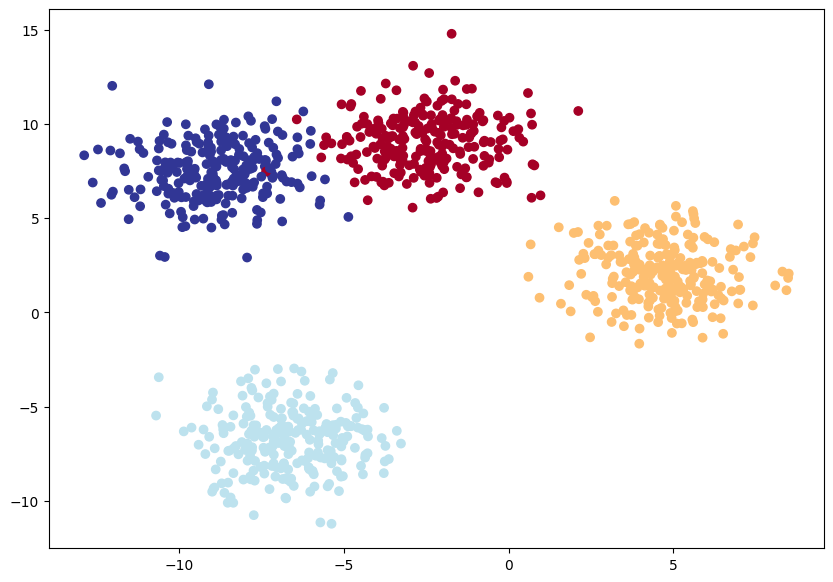

In [6]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [7]:
from torch import nn


class BlobModel(nn.Module):

    def __init__(self, input_features: int, hidden_units: int, output_units: int = 8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_units),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(
    input_features=NUM_FEATURES,
    hidden_units=8,
    output_units=NUM_CLASSES
).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.08)

In [9]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2618,  0.2549,  0.6618,  0.0302],
        [ 0.5531,  0.8556,  0.3921, -0.8837],
        [ 1.0900, -1.4730, -0.6755,  0.0676],
        [ 0.7426, -0.8765, -0.3434, -0.1043],
        [ 0.6160,  0.5664,  0.2606, -0.7642]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Hay cuatro columnas, que son el número de clases. Por lo tanto, da la probabilidad de que sea de una clase u otra.

Como siempre, las predicciones obtenidas por el modelo, hay que pasarla por una softmax

https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier

## La utilización de softmax o sigmoid para sacar las probabilidades del output de una regresión logística.

Softmax es una generalización de sigmoid. Sigmoid se utiliza el predicción binaria mientras que softmax se utiliza en multiclase

In [10]:
y_logics = model_4(X_blob_test.to(device))

y_preds = torch.softmax(y_logics, dim=1)
print(y_logics[:5])
print(y_preds[:5])

tensor([[-1.1412,  0.3890,  0.6810, -0.0764],
        [ 1.5671,  0.4395, -0.0549, -1.0279],
        [ 0.6693, -1.2899, -0.4859,  0.1223],
        [-1.0595, -0.0250,  0.4950,  0.0974],
        [ 0.0626,  0.9782,  0.5773, -0.7756]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.0680, 0.3141, 0.4206, 0.1972],
        [0.6266, 0.2029, 0.1238, 0.0468],
        [0.4915, 0.0693, 0.1548, 0.2844],
        [0.0853, 0.2399, 0.4036, 0.2712],
        [0.1784, 0.4458, 0.2986, 0.0772]], device='cuda:0',
       grad_fn=<SliceBackward0>)


Como es multiclase, debemos de escoger el mayor valor de probabilidad para sacar la predicción final. En este caso utilizamos argmax()

In [11]:
print(y_preds[0])
torch.argmax(y_preds[0])

tensor([0.0680, 0.3141, 0.4206, 0.1972], device='cuda:0',
       grad_fn=<SelectBackward0>)


tensor(2, device='cuda:0')

Nos sale que el mayro valor está en la posición 2, que es, efectivamente el mayor valor entre los cuatro valores

In [12]:
y_preds[0][torch.argmax(y_preds[0])]

tensor(0.4206, device='cuda:0', grad_fn=<SelectBackward0>)

In [13]:
torch.argmax(y_preds[0]).item()

2

### Entrenamiento del modelo multiclase

In [14]:
torch.manual_seed(42)

epochs = 100

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

loss_train = []
acc_train = []

loss_test = []
acc_test = []

epoch_l = []

for epoch in range(epochs):
    epoch_l.append(epoch)
    model_4.train()

    y_logics = model_4(X_blob_train)
    y_preds = torch.softmax(y_logics, dim=1).argmax(dim=1)


    # Cuidado que la función de loss utiliza los y_logics
    loss = loss_fn(y_logics, y_blob_train)
    # Pero la accuracy utiliza las predicciones reales
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)

    loss_train.append(loss.to('cpu').detach().numpy())
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logics = model_4(X_blob_test)
        test_preds = torch.softmax(test_logics, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logics, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        loss_test.append(test_loss.to('cpu').detach().numpy())
        acc_test.append(test_acc)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.94730, Acc: 6.00% | Test Loss: 0.99965, Test Acc: 50.50%
Epoch: 10 | Loss: 0.28460, Acc: 94.25% | Test Loss: 0.25327, Test Acc: 95.50%
Epoch: 20 | Loss: 0.13244, Acc: 98.62% | Test Loss: 0.12418, Test Acc: 99.00%
Epoch: 30 | Loss: 0.08939, Acc: 99.12% | Test Loss: 0.08371, Test Acc: 99.00%
Epoch: 40 | Loss: 0.06891, Acc: 99.00% | Test Loss: 0.06332, Test Acc: 99.00%
Epoch: 50 | Loss: 0.05744, Acc: 99.00% | Test Loss: 0.05152, Test Acc: 99.00%
Epoch: 60 | Loss: 0.05032, Acc: 99.00% | Test Loss: 0.04397, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04555, Acc: 99.00% | Test Loss: 0.03880, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04218, Acc: 99.00% | Test Loss: 0.03506, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03969, Acc: 99.00% | Test Loss: 0.03225, Test Acc: 99.50%


In [16]:
def graficar_loss_acc(epochs: list, loss_train: list = [], acc_train: list = [], loss_test: list = [], acc_test: list = []):
    fig, ax = plt.subplots()

    if len(loss_train) >= 1:
        ax.plot(epochs, loss_train, 'b-', label='Loss Train')

    if len(loss_test) >= 1:
        ax.plot(epochs, loss_test, 'y-', label='Loss Test')

    ax.legend(loc='best')
    ax.set_title('Evaluación del Modelo Multiclase')  # Añadir título a la gráfica
    ax.set_xlabel('Epochs')  # Etiqueta para el eje x
    ax.set_ylabel('Metrics')

    fig, ax = plt.subplots()

    if len(acc_train) >= 1:
        ax.plot(epochs, acc_train, 'g-', label='Acc Train')

    if len(acc_test) >= 1:
        ax.plot(epochs, acc_test, 'r-', label='Acc Test')

    ax.legend(loc='best')
    ax.set_title('Evaluación del Modelo Multiclase')  # Añadir título a la gráfica
    ax.set_xlabel('Epochs')  # Etiqueta para el eje x
    ax.set_ylabel('Metrics')
    plt.show()

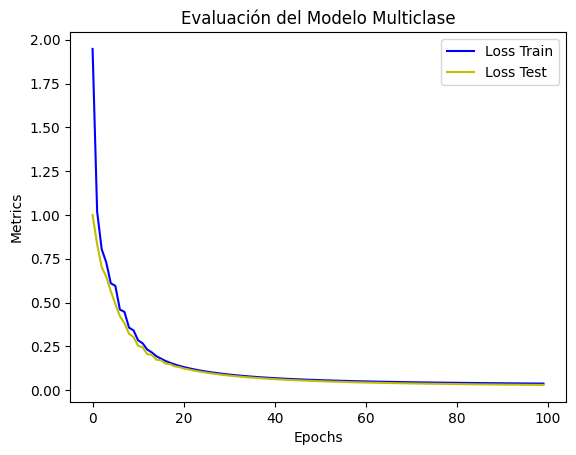

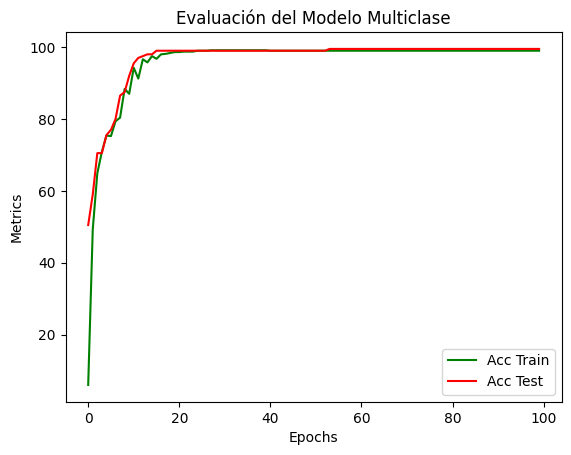

In [17]:
graficar_loss_acc(epoch_l, loss_train, acc_train, loss_test, acc_test) ## No sé por qué, no me funciona

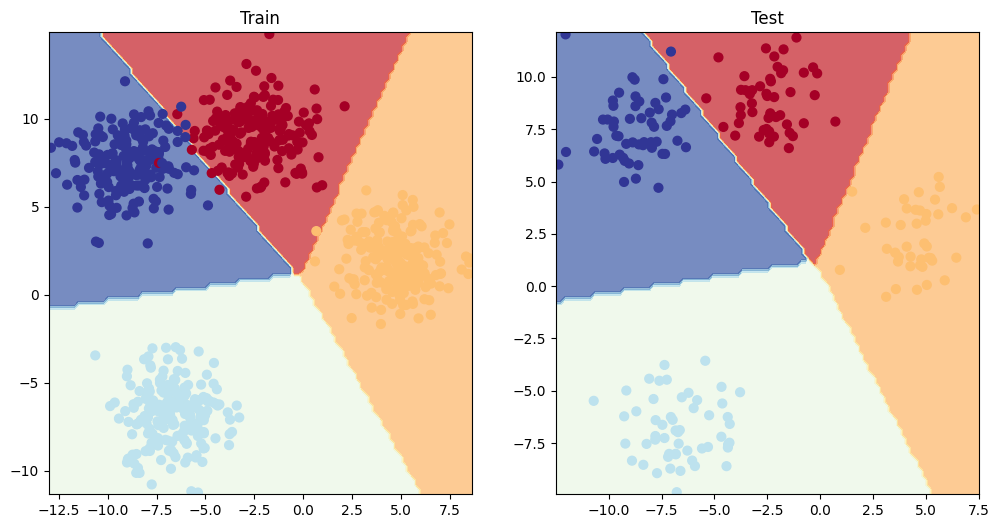

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### Otro tipo de métricas para evaluar el modelo

In [24]:
model_4.to(device)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [19]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

ValueError: The `preds` and `target` should have the same first dimension.

In [20]:
y_preds.shape

torch.Size([800])

In [21]:
y_blob_test.shape

torch.Size([200])